In [0]:
%restart_python

## Queries de inserção dos dados do csv no banco de dados

![](/Workspace/Users/edinhomail@gmail.com/Captura de tela 2025-04-13 032048.png)

In [0]:
O primeiro csv carregado gerou problema, não fazia a separação de colunas e, após fazer a devida separação, os dados eram salvos como string, havendo muita dificuldade para alterar isso, então houve a necessidade de carregar outro e a tabela que havia sido criada com base naquele csv foi apagada e substituída por uma nova, agora com as colunas devidamente separadas e com os tipos de dados corretos.

![](/Workspace/Users/edinhomail@gmail.com/Captura de tela 2025-04-13 033043.png)

In [0]:
# Carregar dados
df_winfut = spark.table("winfut")
display(df_winfut.limit(5))

Date,Open,High,Low,Close
2005-05-17,114815.05,115986.64,113409.16,115611.73
2005-05-18,115518.0,117861.17,115518.0,117392.53
2005-05-19,115986.64,117392.53,115939.77,117392.53
2005-05-20,117158.22,117158.22,115658.59,115986.64
2005-05-23,116455.27,116455.27,114112.1,114112.1


Os dados foram obtidos através da plataforma de trading Profit, exportados para o Excel e salvos no formato csv. Eles contêm dados diários do mini-índice (WINFUT), divididos em cinco colunas: Date, Open (preço de abertura), High (máxima do preço), Low (mínima do preço) e Close (fechamento ou último estado do preço)

In [0]:
print(df_winfut.columns)

['Date', 'Open', 'High', 'Low', 'Close']


In [0]:
# Verificando os tipos dos dados da tabela df_winfut
df_winfut.dtypes

[('Date', 'date'),
 ('Open', 'double'),
 ('High', 'double'),
 ('Low', 'double'),
 ('Close', 'double')]

In [0]:
# Estatísticas dos dados
df_winfut.summary().show()

+-------+------------------+------------------+------------------+------------------+
|summary|              Open|              High|               Low|             Close|
+-------+------------------+------------------+------------------+------------------+
|  count|              4913|              4913|              4913|              4913|
|   mean|148562.28450030496|150083.31765112976|  146988.670793812|  148570.918552819|
| stddev|32523.131606266696| 32791.04266283227|32191.450464563823|32509.395232928422|
|    min|          74945.74|          75615.43|          74495.94|          75185.63|
|    25%|         126127.71|         127499.94|         124900.36|         126219.95|
|    50%|         143098.92|         144381.08|         141443.48|         143133.62|
|    75%|         166260.38|         167898.84|         164490.21|         166318.55|
|    max|         264807.35|         268000.83|         261829.17|         265722.34|
+-------+------------------+------------------+-------

In [0]:
from pyspark.sql.functions import col, isnan, when, count, lit
from pyspark.sql.types import DoubleType

# Identificar colunas numéricas
numeric_cols = [f.name for f in df_winfut.schema.fields if isinstance(f.dataType, DoubleType)]

# Verificar presença de nulos e NaNs
print("🔍 Verificando valores nulos e NaNs por coluna:")
null_nan_check = df_winfut.select([
    count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in numeric_cols
])
null_nan_check.show()

# Verificar valores infinitos (+inf ou -inf)
print("🔍 Verificando valores infinitos por coluna:")
inf_check_exprs = [
    count(when((col(c) == float("inf")) | (col(c) == float("-inf")), c)).alias(c)
    for c in numeric_cols
]
inf_check = df_winfut.select(inf_check_exprs)
inf_check.show()

# Resultado final: se tudo der zero, os dados estão limpos
print("✅ Se todos os valores acima forem zero, seus dados estão limpos.")


🔍 Verificando valores nulos e NaNs por coluna:
+----+----+----+-----+
|Open|High| Low|Close|
+----+----+----+-----+
|2560|2560|2560| 2560|
+----+----+----+-----+

🔍 Verificando valores infinitos por coluna:
+----+----+---+-----+
|Open|High|Low|Close|
+----+----+---+-----+
|   0|   0|  0|    0|
+----+----+---+-----+

✅ Se todos os valores acima forem zero, seus dados estão limpos.


In [0]:
df_winfut.printSchema()


root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)



In [0]:
from pyspark.sql.functions import col

# Converter colunas para double, se necessário
for c in ["Open", "High", "Low", "Close"]:
    df = df_winfut.withColumn(c, col(c).cast("double"))

In [0]:
from pyspark.sql.functions import isnan, isnull, when, count

df.select([
    count(when(isnull(col(c)) | isnan(col(c)), c)).alias(c) for c in ["Open", "High", "Low", "Close"]
]).show()

+----+----+----+-----+
|Open|High| Low|Close|
+----+----+----+-----+
|2560|2560|2560| 2560|
+----+----+----+-----+



In [0]:
from pyspark.sql.functions import col, isnan, isnull, monotonically_increasing_id
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Adicionar índice numérico a cada linha (tipo "linha do CSV original")
df_com_indice = df_winfut.withColumn("row_index", row_number().over(Window.orderBy(monotonically_increasing_id())))

# Verificar quais linhas têm algum problema nas colunas principais
colunas = ["Date", "Open", "High", "Low", "Close"]

linhas_nulas = df_com_indice.filter(
    sum([(col(c).isNull() | (isnan(col(c)) if c in ["Open", "High", "Low", "Close"] else lit(False))).cast("int") for c in colunas]) > 0
)

# Exibir as linhas nulas com o número da linha
linhas_nulas.select("row_index", *colunas).show(50, truncate=False)


/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


+---------+----+----+----+----+-----+
|row_index|Date|Open|High|Low |Close|
+---------+----+----+----+----+-----+
|4914     |NULL|NULL|NULL|NULL|NULL |
|4915     |NULL|NULL|NULL|NULL|NULL |
|4916     |NULL|NULL|NULL|NULL|NULL |
|4917     |NULL|NULL|NULL|NULL|NULL |
|4918     |NULL|NULL|NULL|NULL|NULL |
|4919     |NULL|NULL|NULL|NULL|NULL |
|4920     |NULL|NULL|NULL|NULL|NULL |
|4921     |NULL|NULL|NULL|NULL|NULL |
|4922     |NULL|NULL|NULL|NULL|NULL |
|4923     |NULL|NULL|NULL|NULL|NULL |
|4924     |NULL|NULL|NULL|NULL|NULL |
|4925     |NULL|NULL|NULL|NULL|NULL |
|4926     |NULL|NULL|NULL|NULL|NULL |
|4927     |NULL|NULL|NULL|NULL|NULL |
|4928     |NULL|NULL|NULL|NULL|NULL |
|4929     |NULL|NULL|NULL|NULL|NULL |
|4930     |NULL|NULL|NULL|NULL|NULL |
|4931     |NULL|NULL|NULL|NULL|NULL |
|4932     |NULL|NULL|NULL|NULL|NULL |
|4933     |NULL|NULL|NULL|NULL|NULL |
|4934     |NULL|NULL|NULL|NULL|NULL |
|4935     |NULL|NULL|NULL|NULL|NULL |
|4936     |NULL|NULL|NULL|NULL|NULL |
|4937     |N

Print do CSV

![](/Workspace/Users/edinhomail@gmail.com/Captura de tela 2025-04-13 111840.png)

Como imaginado, problema no csv. Limpamos o arquivo, agora vamos subir de novo e testar.

![](/Workspace/Users/edinhomail@gmail.com/Captura de tela 2025-04-13 113934.png)

In [0]:
from pyspark.sql.functions import col, isnan, when, count, lit
from pyspark.sql.types import DoubleType

# Identificar colunas numéricas
numeric_cols = [f.name for f in df_winfut.schema.fields if isinstance(f.dataType, DoubleType)]

# Verificar presença de nulos e NaNs
print("🔍 Verificando valores nulos e NaNs por coluna:")
null_nan_check = df_winfut.select([
    count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in numeric_cols
])
null_nan_check.show()

# Verificar valores infinitos (+inf ou -inf)
print("🔍 Verificando valores infinitos por coluna:")
inf_check_exprs = [
    count(when((col(c) == float("inf")) | (col(c) == float("-inf")), c)).alias(c)
    for c in numeric_cols
]
inf_check = df_winfut.select(inf_check_exprs)
inf_check.show()

# Resultado final: se tudo der zero, os dados estão limpos
print("✅ Se todos os valores acima forem zero, seus dados estão limpos.")

🔍 Verificando valores nulos e NaNs por coluna:
+----+----+---+-----+
|Open|High|Low|Close|
+----+----+---+-----+
|   0|   0|  0|    0|
+----+----+---+-----+

🔍 Verificando valores infinitos por coluna:
+----+----+---+-----+
|Open|High|Low|Close|
+----+----+---+-----+
|   0|   0|  0|    0|
+----+----+---+-----+

✅ Se todos os valores acima forem zero, seus dados estão limpos.


#Importação de bibliotecas específicas para criação de features baseadas em Análise Técnica e definição de funções para o mesmo fim.

**Análise técnica é um método de avaliação de ativos no mercado financeiro que se baseia exclusivamente no comportamento passado dos preços e volumes de negociação, com o objetivo de prever os movimentos futuros.

A ideia central é:

“O mercado já reflete todas as informações disponíveis nos preços.”

Em resumo:
Usa gráficos de preços e indicadores técnicos (como médias móveis, RSI, MACD, etc).

Não se preocupa com fundamentos da empresa (como lucro, dívida ou setor).

Parte do princípio de que os preços se movimentam em tendências e que padrões históricos tendem a se repetir.

Utiliza suportes, resistências, figuras gráficas (triângulos, bandeiras, etc) e velas (candlesticks) como ferramentas visuais.

Aqui, em suma, usaremos o RSI, RSL (Relative Strengh of Levy), Awesome Oscilator e funções de nossa lavra como a find_divergences e calculate_points_recency que, respectivamente, encontra divergências entre topos e fundos de indicadores osciladores (RSI, RSL etc) e topos e fundos formados pelos preços e calcula a recência de pontos positivos e negativos do mini-índice futuro (ativo base do estudo).

Algumas outras features e transformações nos dados serão detalhadas ao longo do desenvolvimento do código.**

In [0]:
%pip install ta

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
!pip install tabulate

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import ta
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
import seaborn as sns
import matplotlib.pyplot as plt


# Definição de funções

def clean_for_model(df, target, features):
    return df[[target] + features].replace([np.inf, -np.inf], np.nan).dropna()
    

def calculate_log_returns(data, lag):
    """
    Calcula os log-returns para uma única coluna e um único lag.
    
    Parameters
    ----------
    data : pd.Series
        Dados para cálculo dos log-returns. Deve ser uma Series.
    lag : int
        Lag para calcular os retornos.
    
    Returns
    -------
    pd.Series
        Série com os log-returns calculados para o lag especificado.
    """
    
    # Garantir que o dado seja uma Series
    if not isinstance(data, pd.Series):
        raise ValueError("O argumento `data` deve ser uma Series.")

    epsilon = 1e-10  # Para evitar divisão por zero

    # Calcular log-returns
    shifted = data.shift(lag)
    ratio = (data + epsilon) / (shifted + epsilon)
    log_return = np.log(ratio)

    return log_return





def calculate_points_recency(data, points_column='DifPoints', 
                           positive_col_name='recency_positive',
                           negative_col_name='recency_negative'):
    """
    Calcula a recência (dias desde a última ocorrência) de pontos positivos e negativos.
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame contendo a coluna de pontos
    points_column : str
        Nome da coluna que contém os pontos diários
    positive_col_name : str
        Nome desejado para a coluna de recência de pontos positivos
    negative_col_name : str
        Nome desejado para a coluna de recência de pontos negativos
        
    Returns:
    --------
    pd.DataFrame
        DataFrame com duas novas colunas:
        - {positive_col_name}: dias desde o último ponto positivo
        - {negative_col_name}: dias desde o último ponto negativo
    """
    
    # Cria máscaras para pontos positivos e negativos
    positive_mask = data[points_column] > 0
    negative_mask = data[points_column] < 0
    
    # Inicializa arrays para armazenar as recências
    recency_positive = np.zeros(len(data))
    recency_negative = np.zeros(len(data))
    
    # Contador para dias desde último evento
    days_since_positive = 0
    days_since_negative = 0
    
    # Calcula a recência para cada dia
    for i in range(len(data)):
        if positive_mask.iloc[i]:
            days_since_positive = 0
        else:
            days_since_positive += 1
            
        if negative_mask.iloc[i]:
            days_since_negative = 0
        else:
            days_since_negative += 1
            
        recency_positive[i] = days_since_positive
        recency_negative[i] = days_since_negative
    
    # Cria DataFrame com os resultados usando os nomes personalizados
    results = pd.DataFrame({
        positive_col_name: recency_positive,
        negative_col_name: recency_negative
    }, index=data.index)
    
    return results




def find_divergences(
    df,
    price_col='Close',
    indicator_col='RSL20',
    order=5,
    lookback=None,
    min_swing_strength = 0.1
):
    """
    Detecta divergências entre preço e indicador.
    """
    price = df[price_col].values
    indi = df[indicator_col].values
    
    div_bullish_col = f"{price_col}_{indicator_col}_divergence_bullish"
    div_bearish_col = f"{price_col}_{indicator_col}_divergence_bearish"
    df[div_bullish_col] = 0
    df[div_bearish_col] = 0
    
    price_max_idx = argrelextrema(price, np.greater, order=order)[0]
    price_min_idx = argrelextrema(price, np.less, order=order)[0]
    
    def filter_weak_swings(peaks, troughs):
        valid_peaks = []
        valid_troughs = []
        
        for peak in peaks:
            prev_trough = troughs[troughs < peak][-1] if len(troughs[troughs < peak]) > 0 else None
            next_trough = troughs[troughs > peak][0] if len(troughs[troughs > peak]) > 0 else None
            
            if prev_trough is not None and next_trough is not None:
                swing_strength = min(
                    abs(price[peak] - price[prev_trough]) / max(abs(price[prev_trough]), 1e-12),
                    abs(price[peak] - price[next_trough]) / max(abs(price[next_trough]), 1e-12)
                )
                if swing_strength >= min_swing_strength:
                    valid_peaks.append(peak)
        
        for trough in troughs:
            prev_peak = peaks[peaks < trough][-1] if len(peaks[peaks < trough]) > 0 else None
            next_peak = peaks[peaks > trough][0] if len(peaks[peaks > trough]) > 0 else None
            
            if prev_peak is not None and next_peak is not None:
                swing_strength = min(
                    abs(price[prev_peak] - price[trough]) / max(abs(price[trough]), 1e-12),
                    abs(price[next_peak] - price[trough]) / max(abs(price[trough]), 1e-12)
                )
                if swing_strength >= min_swing_strength:
                    valid_troughs.append(trough)
        
        return np.array(valid_peaks), np.array(valid_troughs)
    
    price_max_idx, price_min_idx = filter_weak_swings(price_max_idx, price_min_idx)
    
    def find_local_extrema(idx, values, is_bullish):
        if len(idx) < 2:
            return None
        
        segment = values[idx[0]:idx[1]+1]
        if is_bullish:
            return np.min(segment)
        return np.max(segment)
    

def calculate_rsl(prices, timeperiod=14):
        """
        Calculate the Relative Strength Levy (RSL) for a given series of prices.
        
        Parameters:
        prices (pd.Series): Series of closing prices.
        period (int): Period over which to calculate the RSL.
        
        Returns:
        pd.Series: Series of RSL values.
        """
        # Calculate the moving average of the closing prices
        rolling_mean = prices.rolling(window=timeperiod).mean()
        
        # Calculate RSL
        rsl = (prices / rolling_mean) - 1
        
        return rsl


In [0]:
pd_feat = df_winfut.toPandas()

In [0]:
# Transformar a coluna Date em índice
pd_feat.set_index('Date', inplace=True)

##Features relacionadas ao candlestick em si
**Body** é o corpo do candle ou o número de pontos alcançados pelo mini-índice no dia (o período é diário)

**Shadow** é o pavio deixado pelo movimento dos preços, são máximas e as mínimas do dia

In [0]:
pd_feat['Body'] = pd_feat['Close'] - pd_feat['Open']

pd_feat['Amplitude'] = pd_feat['High'] - pd_feat['Low']

# Pavio superior (Upper Shadow)
pd_feat['Upper_Shadow'] = pd_feat['High'] - pd_feat[['Open', 'Close']].max(axis=1)

# Pavio inferior (Lower Shadow)
pd_feat['Lower_Shadow'] = pd_feat[['Open', 'Close']].min(axis=1) - pd_feat['Low']

# Lower_Shadow / Amplitude
pd_feat['Lower_Shadow_Ratio'] = pd_feat['Lower_Shadow'] / pd_feat['Amplitude']

# Upper_Shadow / Amplitude
pd_feat['Upper_Shadow_Ratio'] = pd_feat['Upper_Shadow'] / pd_feat['Amplitude']

# Lower_Shadow / Upper_Shadow
pd_feat['Lower_Shadow_Upper_Shadow_Ratio'] = pd_feat['Lower_Shadow'] / pd_feat['Upper_Shadow']

# Body / Amplitude
pd_feat['Body_Amplitude_Ratio'] = pd_feat['Body'] / pd_feat['Amplitude']

# Lower_Shadow / Body
pd_feat['Lower_Shadow_Body_Ratio'] = pd_feat['Lower_Shadow'] / pd_feat['Body']

# Upper_Shadow / Body
pd_feat['Upper_Shadow_Body_Ratio'] = pd_feat['Upper_Shadow'] / pd_feat['Body']

In [0]:
# Features relacionadas aos retornos
pd_feat['returns'] = calculate_log_returns(pd_feat['Close'], 1)
pd_feat['returns_Sum_5'] = pd_feat['returns'].rolling(5).sum()
pd_feat['returns_Sum_10'] = pd_feat['returns'].rolling(10).sum()
pd_feat['returns_Sum_20'] = pd_feat['returns'].rolling(20).sum()
pd_feat['returns_Sum_30'] = pd_feat['returns'].rolling(30).sum()
pd_feat['returns_Sum_60'] = pd_feat['returns'].rolling(60).sum()

In [0]:
# Features relacionadas à distância da média - RSL

pd_feat['RSL5'] = calculate_rsl(pd_feat['Close'], 5)
pd_feat['RSL10'] = calculate_rsl(pd_feat['Close'], 10)
pd_feat['RSL20'] = calculate_rsl(pd_feat['Close'], 20)
pd_feat['RSL30'] = calculate_rsl(pd_feat['Close'], 30)
pd_feat['RSL60'] =  calculate_rsl(pd_feat['Close'], 60)

In [0]:
# RSI - Relative Strength Index - usando a lib ta
pd_feat['RSI2'] = ta.momentum.RSIIndicator(pd_feat['Close'], window=2).rsi()
pd_feat['RSI5'] = ta.momentum.RSIIndicator(pd_feat['Close'], window=5).rsi()
pd_feat['RSI14'] = ta.momentum.RSIIndicator(pd_feat['Close'], window=14).rsi()
pd_feat['RSI30'] = ta.momentum.RSIIndicator(pd_feat['Close'], window=30).rsi()
pd_feat['RSI60'] = ta.momentum.RSIIndicator(pd_feat['Close'], window=60).rsi()

In [0]:
# Awesome Oscilator
pd_feat['AO_5_20'] = ta.momentum.AwesomeOscillatorIndicator(pd_feat['High'], pd_feat['Low'], window1=5, window2=20).awesome_oscillator
pd_feat['AO_10_50'] = ta.momentum.AwesomeOscillatorIndicator(pd_feat['High'], pd_feat['Low'], window1=10, window2=50).awesome_oscillator
pd_feat['AO_50_100'] = ta.momentum.AwesomeOscillatorIndicator(pd_feat['High'], pd_feat['Low'], window1=50, window2=200).awesome_oscillator


In [0]:
# Lag Features
for i in range(1, 6):
    pd_feat['Body_lag' + str(i)] = pd_feat['Body'].shift(i)
    pd_feat['Amplitude_lag' + str(i)] = pd_feat['Amplitude'].shift(i)
    pd_feat['Upper_Shadow_lag' + str(i)] = pd_feat['Upper_Shadow'].shift(i)
    pd_feat['Lower_Shadow_lag' + str(i)] = pd_feat['Lower_Shadow'].shift(i)
    pd_feat['Body_Amplitude_Ratio_lag' + str(i)] = pd_feat['Body_Amplitude_Ratio'].shift(i)
    pd_feat['returns_lag' + str(i)] = pd_feat['returns'].shift(i)
pd_feat.dropna(inplace=True)

In [0]:
# Construção do Target - criar três classes - classe Compra: igual ou maior a 400 pontos; Venda: menor ou igual a -400 pontos; Neutro: entre -400 e 400 pontos
body_shifted = pd_feat['Body'].shift(-1)

conditions = [body_shifted >= 400, body_shifted <= -400]
choices = [1, -1]

pd_feat['Target'] = np.select(conditions, choices, default=0)

pd_feat.dropna(inplace=True)

In [0]:
# Preparar a lista de features
#features = pd_feat.drop(columns=['Target', 'Body', 'Open', 'High', 'Low', 'Close'])
# No final, quando fui exportar o notebook, houve um problema de memória pelo excesso de outputs, a solução foi diminuir o número de features
features = ['Amplitude', 'Upper_Shadow', 'Lower_Shadow', 'Lower_Shadow_Ratio', 'Upper_Shadow_Ratio']
features = pd_feat[features]

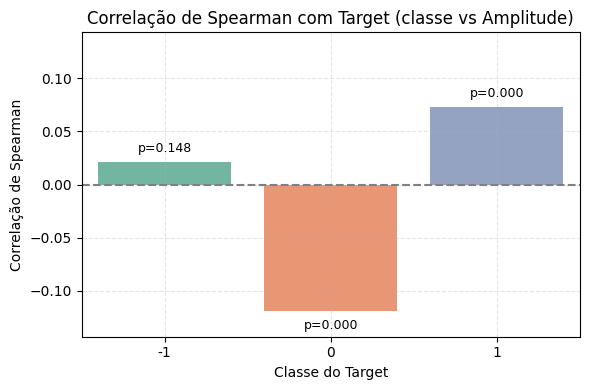

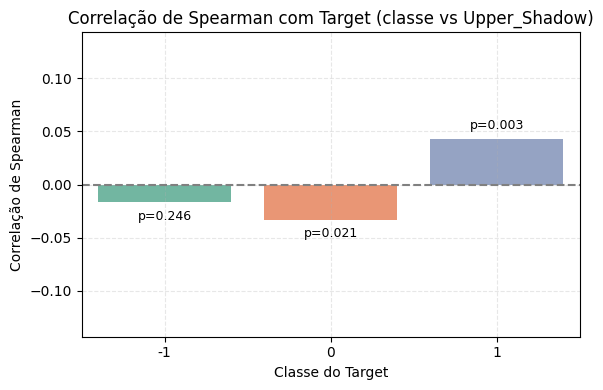

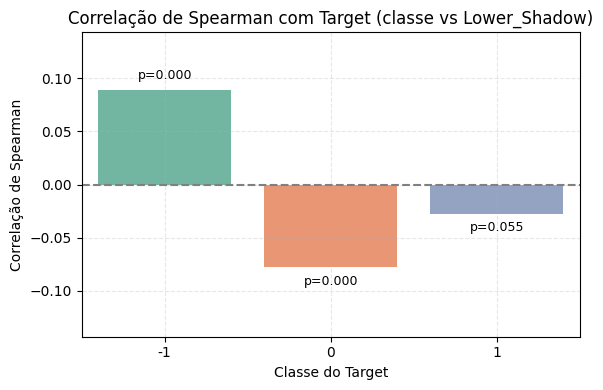

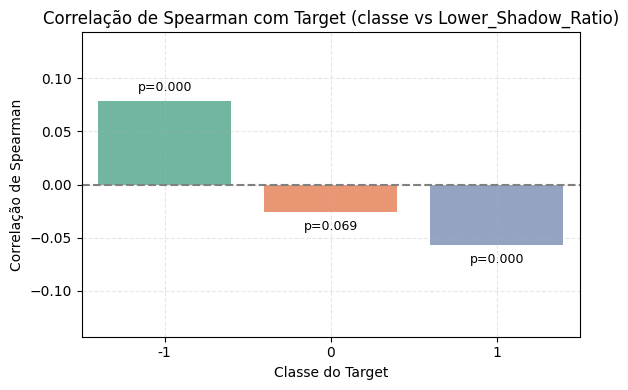

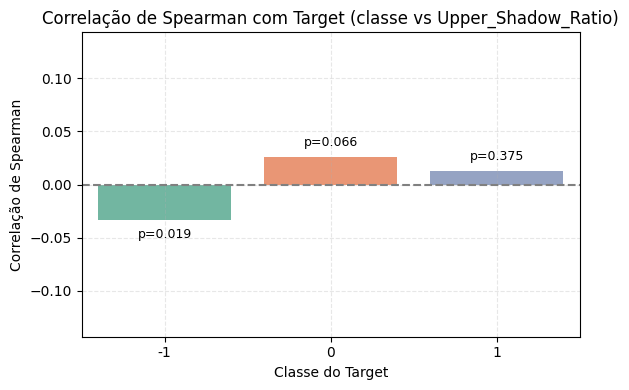

In [0]:
from scipy.stats import spearmanr

# Calcular correlações e p-valores one-vs-rest por classe
corr_pval_list = []

for feature in features:
    if pd_feat[feature].nunique() <= 1:
        continue  # Ignorar colunas constantes
    for target_class in [-1, 0, 1]:
        bin_target = (pd_feat['Target'] == target_class).astype(int)
        corr, pval = spearmanr(pd_feat[feature], bin_target)
        if not np.isfinite(corr) or not np.isfinite(pval):
            continue
        corr_pval_list.append({
            'Feature': feature,
            'Classe': str(target_class),
            'Correlacao': round(corr, 4),
            'Pvalor': round(pval, 4)
        })

# Transformar em DataFrame
plot_final = pd.DataFrame(corr_pval_list)

# Definir um tamanho consistente para todos os gráficos
fig_width = 6
fig_height = 4

# Encontrar o valor máximo absoluto para manter a mesma escala em todos os gráficos
max_corr = max(abs(plot_final['Correlacao'].max()), abs(plot_final['Correlacao'].min()))
# Adicionar 20% de margem para os textos
y_limit = max_corr * 1.2

# Plotar um gráfico por vez com tamanho fixo
for feature in plot_final['Feature'].unique():
    subset = plot_final[plot_final['Feature'] == feature]
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(data=subset, x='Classe', y='Correlacao', palette="Set2")
    
    # Usar os mesmos limites para todos os gráficos
    plt.ylim(-y_limit, y_limit)
    
    # Ajustar o posicionamento dos textos de p-valor
    for i, row in enumerate(subset.itertuples()):
        # Calcular o deslocamento apropriado para o texto
        text_offset = y_limit * 0.05  # 5% do limite do eixo Y
        
        # Posicionar o texto acima ou abaixo da barra conforme o valor de correlação
        y_pos = row.Correlacao + text_offset if row.Correlacao >= 0 else row.Correlacao - text_offset
        
        # Garantir que o texto não saia dos limites
        if row.Correlacao >= 0:
            va = 'bottom'
            if y_pos > y_limit * 0.9:
                y_pos = y_limit * 0.9
        else:
            va = 'top'
            if y_pos < -y_limit * 0.9:
                y_pos = -y_limit * 0.9
        
        # Adicionar texto do p-valor
        ax.text(i, y_pos, f"p={row.Pvalor:.3f}", ha='center', va=va, fontsize=9)
    
    plt.title(f"Correlação de Spearman com Target (classe vs {feature})")
    plt.axhline(0, color='gray', linestyle='--')
    plt.ylabel("Correlação de Spearman")
    plt.xlabel("Classe do Target")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

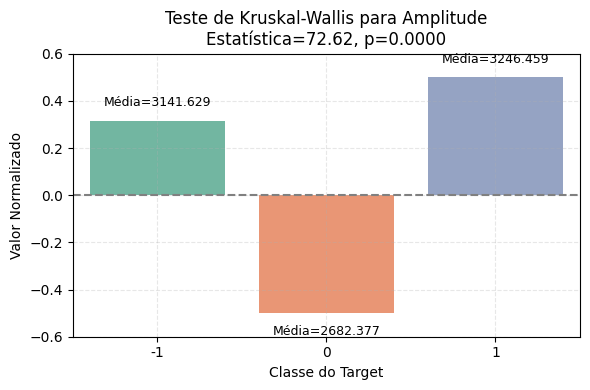

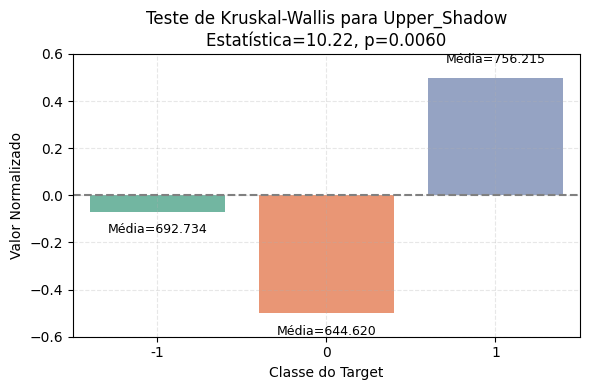

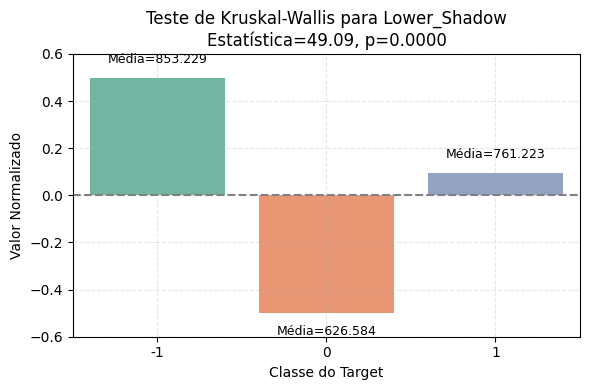

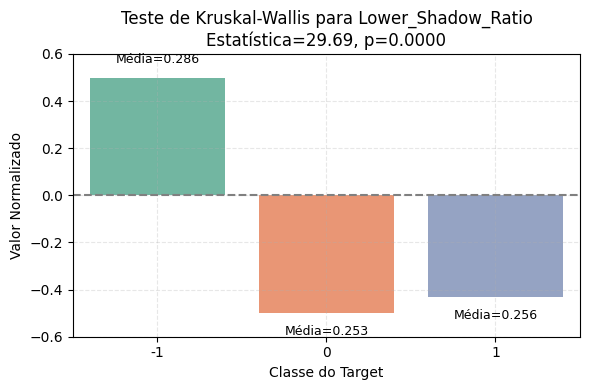

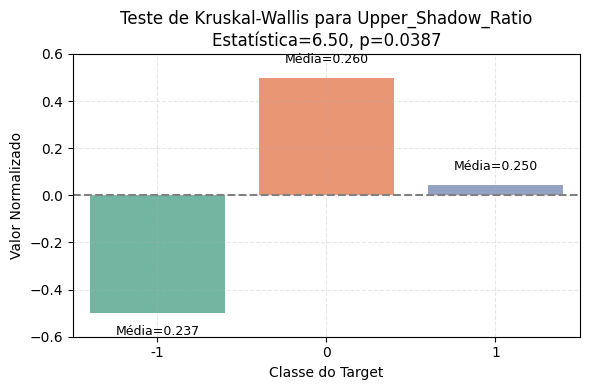

In [0]:
from scipy.stats import kruskal
import warnings
# Ignorar avisos para evitar interrupções
warnings.filterwarnings('ignore')

# Lista para armazenar resultados do teste
kw_results = []

for feature in features:
    if pd_feat[feature].nunique() <= 1:
        continue  # Ignorar colunas constantes
    
    # Obter os valores da feature para cada classe do target
    class_neg1 = pd_feat[pd_feat['Target'] == -1][feature].dropna()
    class_0 = pd_feat[pd_feat['Target'] == 0][feature].dropna()
    class_1 = pd_feat[pd_feat['Target'] == 1][feature].dropna()
    
    # Verificar se temos pelo menos 2 grupos com dados suficientes para o teste
    valid_groups = 0
    for group in [class_neg1, class_0, class_1]:
        if len(group) > 1:
            valid_groups += 1
    
    if valid_groups < 2:
        continue
    
    try:
        # Realizar o teste de Kruskal-Wallis
        statistic, pvalue = kruskal(class_neg1, class_0, class_1)
        
        # Armazenar o resultado para cada classe
        # Como Kruskal-Wallis é um teste global, vamos calcular a média de cada grupo
        # para entender a direção da diferença
        kw_results.append({
            'Feature': feature,
            'Classe': '-1',
            'KW_Statistic': round(statistic, 4),
            'Pvalor': round(pvalue, 4),
            'Mean_Value': np.mean(class_neg1)
        })
        
        kw_results.append({
            'Feature': feature,
            'Classe': '0', 
            'KW_Statistic': round(statistic, 4),
            'Pvalor': round(pvalue, 4),
            'Mean_Value': np.mean(class_0)
        })
        
        kw_results.append({
            'Feature': feature,
            'Classe': '1',
            'KW_Statistic': round(statistic, 4),
            'Pvalor': round(pvalue, 4),
            'Mean_Value': np.mean(class_1)
        })
    except ValueError as e:
        # Caso o teste não possa ser realizado
        print(f"Não foi possível calcular Kruskal-Wallis para {feature}: {e}")

# Transformar em DataFrame
plot_final = pd.DataFrame(kw_results)

# Definir um tamanho consistente para todos os gráficos
fig_width = 6
fig_height = 4

# Plotar um gráfico por vez
for feature in plot_final['Feature'].unique():
    subset = plot_final[plot_final['Feature'] == feature]
    
    # Normalizar os valores médios para melhor visualização
    mean_values = subset['Mean_Value'].values
    mean_min, mean_max = np.min(mean_values), np.max(mean_values)
    
    if mean_min == mean_max:
        # Evitar divisão por zero
        normalized_values = np.zeros_like(mean_values)
    else:
        # Normalizar para o intervalo [-0.5, 0.5]
        normalized_values = ((mean_values - mean_min) / (mean_max - mean_min)) - 0.5
    
    # Adicionar valores normalizados ao subset
    subset = subset.copy()
    subset['Normalized_Value'] = normalized_values
    
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(data=subset, x='Classe', y='Normalized_Value', palette="Set2")
    
    # Usar limites consistentes
    y_limit = 0.6  # um pouco mais do que 0.5 para ter espaço para o texto
    plt.ylim(-y_limit, y_limit)
    
    # Pegar o valor de estatística e p-valor (serão os mesmos para todas as classes)
    kw_stat = subset['KW_Statistic'].iloc[0]
    p_val = subset['Pvalor'].iloc[0]
    
    # Adicionar título com estatística do teste
    plt.title(f"Teste de Kruskal-Wallis para {feature}\nEstatística={kw_stat:.2f}, p={p_val:.4f}")
    
    # Ajustar os textos das médias reais
    for i, row in enumerate(subset.itertuples()):
        # Posicionar o texto acima ou abaixo da barra
        y_pos = row.Normalized_Value + 0.05 if row.Normalized_Value >= 0 else row.Normalized_Value - 0.05
        
        va = 'bottom' if row.Normalized_Value >= 0 else 'top'
        
        # Adicionar texto com o valor médio real
        ax.text(i, y_pos, f"Média={row.Mean_Value:.3f}", ha='center', va=va, fontsize=9)
    
    plt.axhline(0, color='gray', linestyle='--')
    plt.ylabel("Valor Normalizado")
    plt.xlabel("Classe do Target")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

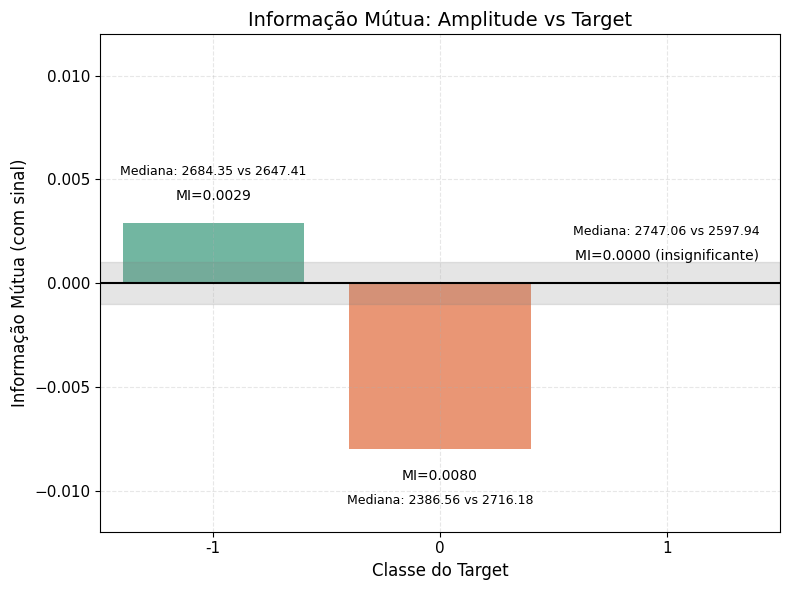

Aviso: Feature Upper_Shadow tem valores de MI muito próximos de zero.


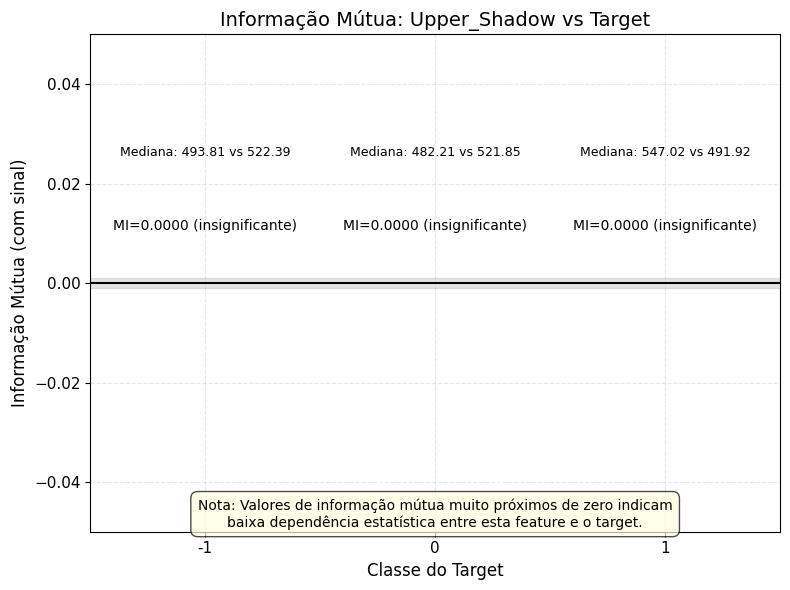

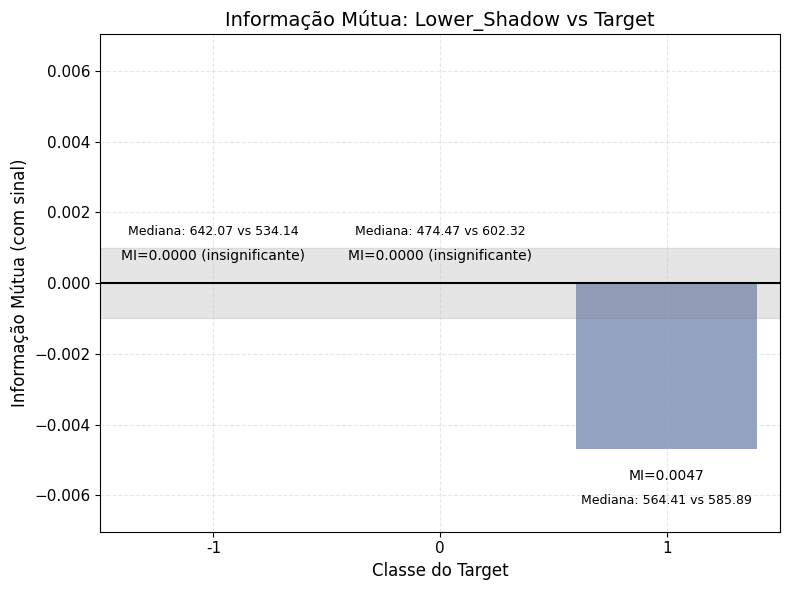

Aviso: Feature Lower_Shadow_Ratio tem valores de MI muito próximos de zero.


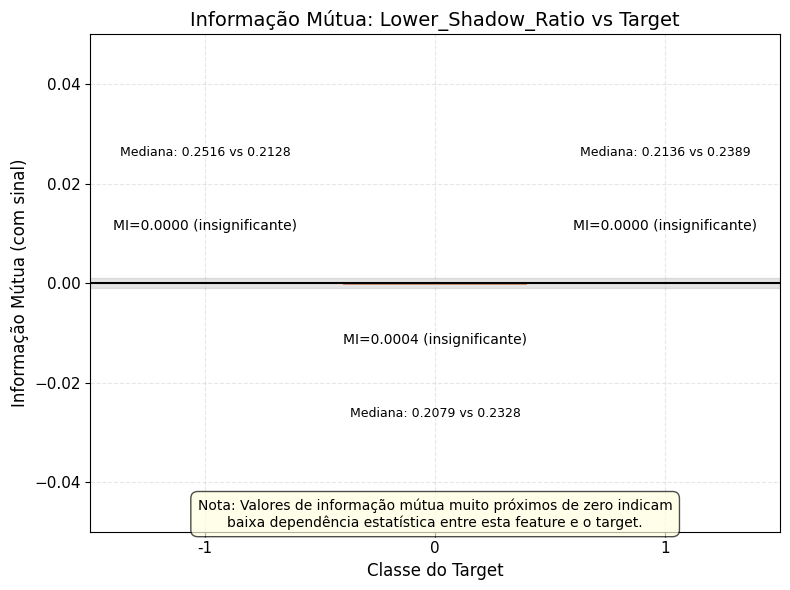

Aviso: Feature Upper_Shadow_Ratio tem valores de MI muito próximos de zero.


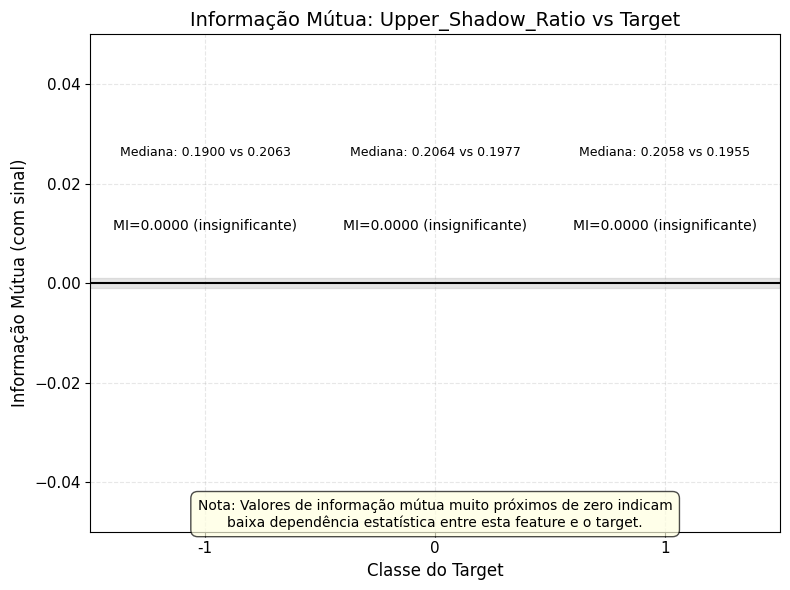

In [0]:
from sklearn.feature_selection import mutual_info_classif
import warnings
# Ignorar avisos
warnings.filterwarnings('ignore')

# Função auxiliar para formatar valores numéricos
def format_value(val):
    if abs(val) == 0:
        return "0"
    elif abs(val) < 0.001 or abs(val) >= 10000:
        return f"{val:.2e}"  # Notação científica
    elif abs(val) < 1:
        return f"{val:.4f}"
    else:
        return f"{val:.2f}"

# Lista para armazenar resultados de informação mútua
mi_results = []

for feature in features:
    if pd_feat[feature].nunique() <= 1:
        continue  # Ignorar colunas constantes
    
    # Obter os valores da feature
    feature_values = pd_feat[feature].values.reshape(-1, 1)
    
    # Verificar se há valores muito grandes ou infinitos
    problematic_values = ~np.isfinite(feature_values) | (np.abs(feature_values) > 1e15)
    if np.any(problematic_values):
        # Criar uma cópia para não modificar os dados originais
        feature_cleaned = feature_values.copy()
        # Substituir valores problemáticos por NaN
        feature_cleaned[problematic_values] = np.nan
        # Usar a versão limpa
        feature_values = feature_cleaned
    
    # Identificar índices válidos após limpeza
    valid_indices = ~np.isnan(feature_values.ravel())
    
    if np.sum(valid_indices) <= 1:
        print(f"Feature {feature} tem muito poucos valores válidos após limpeza, pulando.")
        continue
    
    try:
        # Calcular informação mútua para cada classe vs. resto
        for target_class in [-1, 0, 1]:
            # Criar target binário (classe atual vs. resto)
            bin_target = (pd_feat['Target'] == target_class).astype(int)
            
            # Garantir que estamos usando apenas índices válidos
            X_valid = feature_values[valid_indices]
            y_valid = bin_target.values[valid_indices]
            
            # Verificar se há pelo menos dois valores de classe
            unique_classes = np.unique(y_valid)
            if len(unique_classes) < 2:
                print(f"Feature {feature} para classe {target_class} não tem ambas as classes, pulando.")
                continue
            
            # Calcular informação mútua
            mi_score = mutual_info_classif(X_valid, y_valid, discrete_features=False, random_state=42)[0]
            
            # Calcular o valor mediano da feature original para cada classe
            class_values = pd_feat[pd_feat['Target'] == target_class][feature].dropna()
            non_class_values = pd_feat[pd_feat['Target'] != target_class][feature].dropna()
            
            # Usar mediana para maior robustez a outliers
            class_central = np.median(class_values) if len(class_values) > 0 else 0
            non_class_central = np.median(non_class_values) if len(non_class_values) > 0 else 0
            
            # Determinar a direção com base na diferença das medianas
            direction = 1 if class_central > non_class_central else -1
            
            # A informação mútua é sempre >= 0, mas adicionamos um sinal para indicar a direção
            signed_mi = mi_score * direction
            
            mi_results.append({
                'Feature': feature,
                'Classe': str(target_class),
                'MI_Score': mi_score,
                'Signed_MI': signed_mi,
                'Class_Central': class_central,
                'Non_Class_Central': non_class_central
            })
    except Exception as e:
        print(f"Erro ao processar feature {feature}: {e}")

# Transformar em DataFrame
plot_final = pd.DataFrame(mi_results)

# Verificar se temos resultados antes de plotar
if len(plot_final) == 0:
    print("Nenhum resultado válido encontrado para plotar.")
else:
    # Definir um tamanho maior para os gráficos
    fig_width = 8
    fig_height = 6
    
    # Plotar um gráfico por vez
    for feature in plot_final['Feature'].unique():
        subset = plot_final[plot_final['Feature'] == feature]
        
        # Verificar se os valores são todos muito próximos de zero
        max_abs_mi = subset['Signed_MI'].abs().max()
        
        plt.figure(figsize=(fig_width, fig_height))
        
        # Usar Signed_MI para o gráfico de barras
        ax = sns.barplot(data=subset, x='Classe', y='Signed_MI', palette="Set2")
        
        # Definir limites do eixo Y dependendo da magnitude dos valores
        if max_abs_mi < 0.001:
            # Para valores muito pequenos, usar uma escala fixa em vez de adaptativa
            plt.ylim(-0.05, 0.05)
            y_limit = 0.05
            print(f"Aviso: Feature {feature} tem valores de MI muito próximos de zero.")
        else:
            # Definir limites do eixo Y com espaço adicional para os textos
            y_limit = max_abs_mi * 1.5  # Aumentado para 50% mais espaço
            plt.ylim(-y_limit if min(subset['Signed_MI']) < 0 else 0, y_limit)
        
        # Adicionar bandas para mostrar significância
        plt.axhspan(-0.001, 0.001, alpha=0.2, color='gray', label='Muito baixa significância')
        
        # Formatar os números adequadamente
        for i, row in enumerate(subset.itertuples()):
            # Texto do valor de MI
            mi_text = f"MI={row.MI_Score:.4f}"
            
            # Para valores muito pequenos de MI, adicionar anotação
            if abs(row.MI_Score) < 0.001:
                mi_text += " (insignificante)"
            
            # Formatar valores para exibição adequada
            class_central_str = format_value(row.Class_Central)
            non_class_central_str = format_value(row.Non_Class_Central)
            
            # Posições dos textos
            if max_abs_mi < 0.001:
                # Para valores muito pequenos, posicionar textos em locais fixos
                mi_text_pos = 0.01 if row.Signed_MI >= 0 else -0.01
                central_text_pos = 0.025 if row.Signed_MI >= 0 else -0.025
                va_mi = 'bottom' if row.Signed_MI >= 0 else 'top'
                va_central = 'bottom' if row.Signed_MI >= 0 else 'top'
            else:
                # Cálculo normal para valores significativos
                if row.Signed_MI >= 0:
                    mi_text_pos = row.Signed_MI + (y_limit * 0.08)
                    central_text_pos = row.Signed_MI + (y_limit * 0.18)
                    va_mi = 'bottom'
                    va_central = 'bottom'
                else:
                    mi_text_pos = row.Signed_MI - (y_limit * 0.08)
                    central_text_pos = row.Signed_MI - (y_limit * 0.18)
                    va_mi = 'top'
                    va_central = 'top'
            
            # Texto da informação mútua
            ax.text(i, mi_text_pos, mi_text, ha='center', va=va_mi, fontsize=10)
            
            # Texto das medianas em formato mais compacto
            ax.text(i, central_text_pos, 
                   f"Mediana: {class_central_str} vs {non_class_central_str}", 
                   ha='center', va=va_central, fontsize=9)
        
        plt.title(f"Informação Mútua: {feature} vs Target", fontsize=14)
        plt.axhline(0, color='black', linestyle='-', linewidth=1.5)
        plt.ylabel("Informação Mútua (com sinal)", fontsize=12)
        plt.xlabel("Classe do Target", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.3)
        
        # Adicionar anotação quando os valores são muito baixos
        if max_abs_mi < 0.001:
            plt.annotate("Nota: Valores de informação mútua muito próximos de zero indicam\n"
                         "baixa dependência estatística entre esta feature e o target.",
                         xy=(0.5, 0.01), xycoords='axes fraction',
                         bbox=dict(boxstyle="round,pad=0.5", facecolor='lightyellow', alpha=0.7),
                         horizontalalignment='center', fontsize=10)
        
        # Aumentar o tamanho dos ticks nos eixos
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)
        
        # Ajustar layout
        plt.tight_layout()
        plt.show()

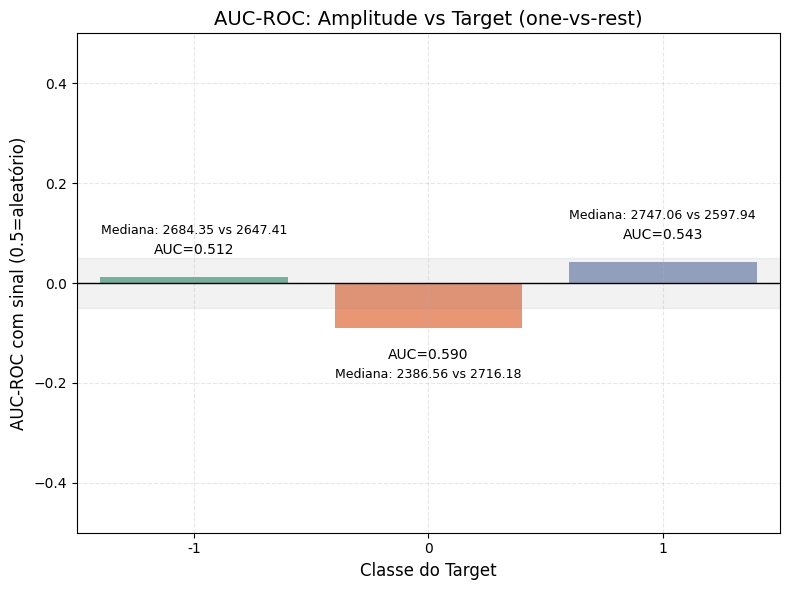

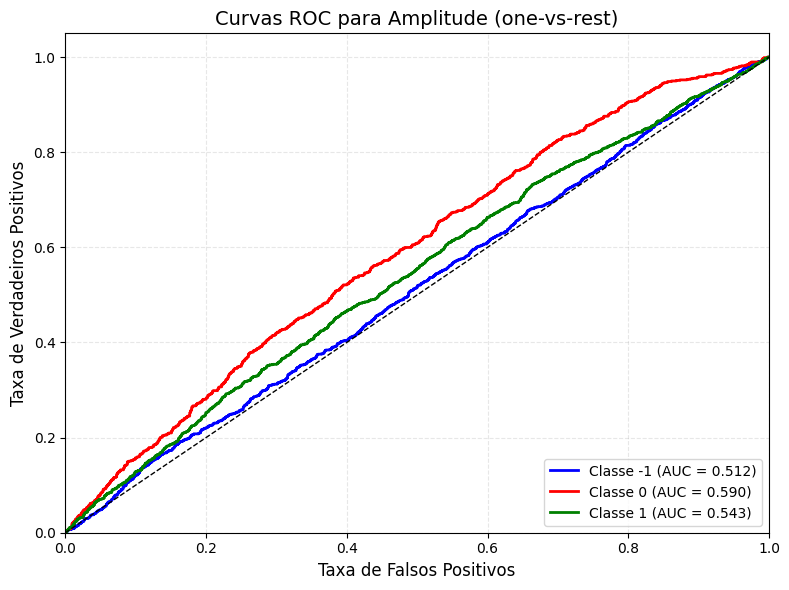

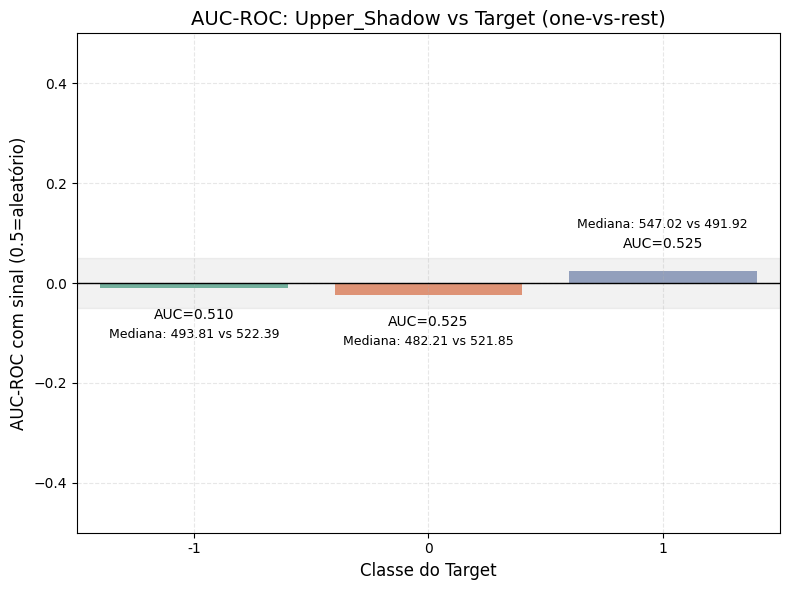

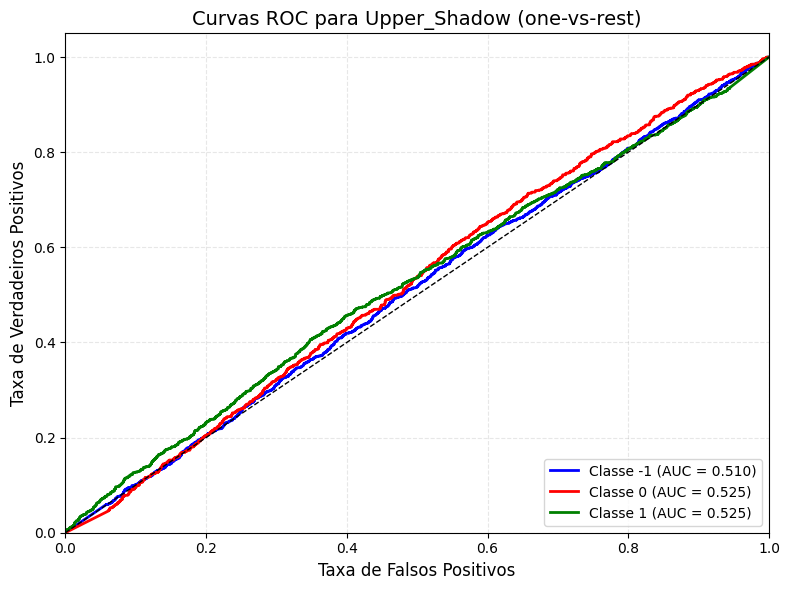

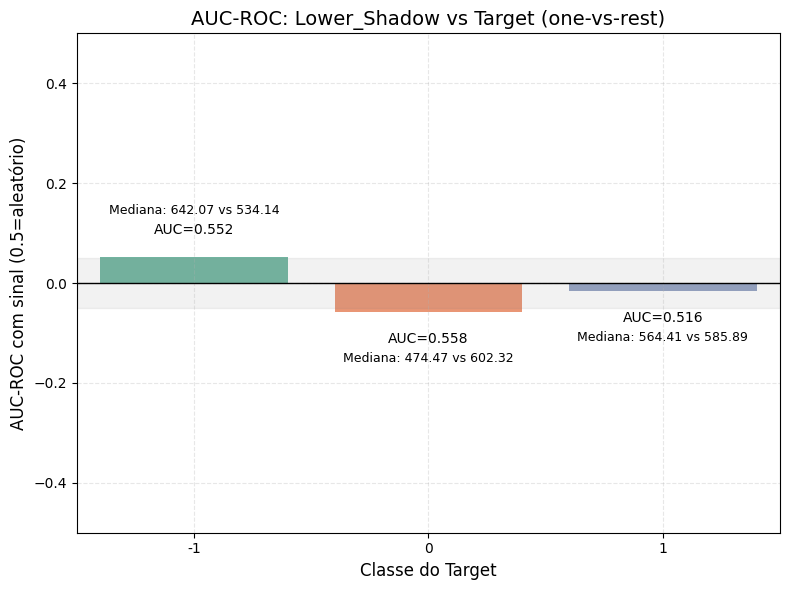

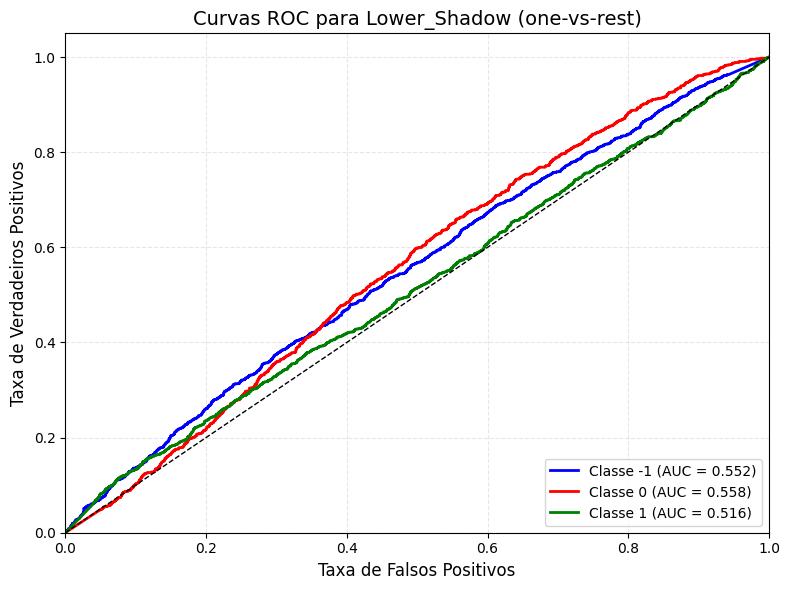

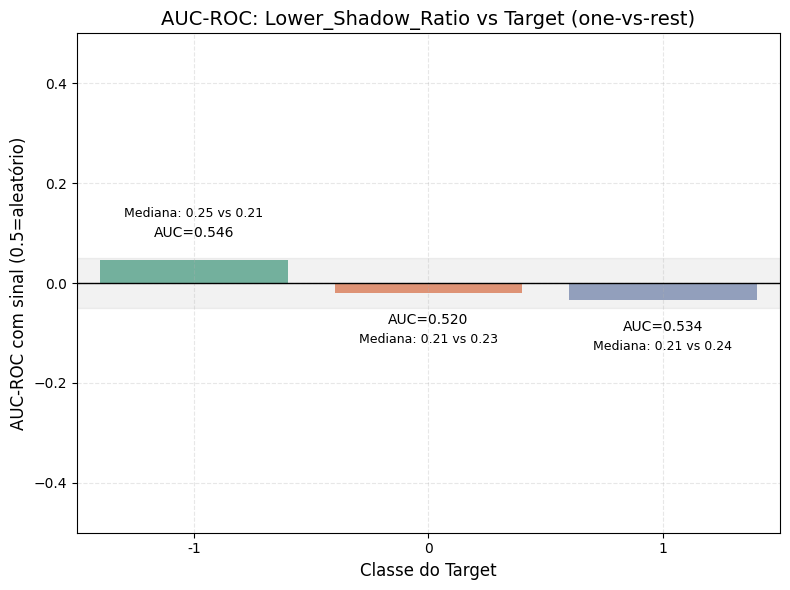

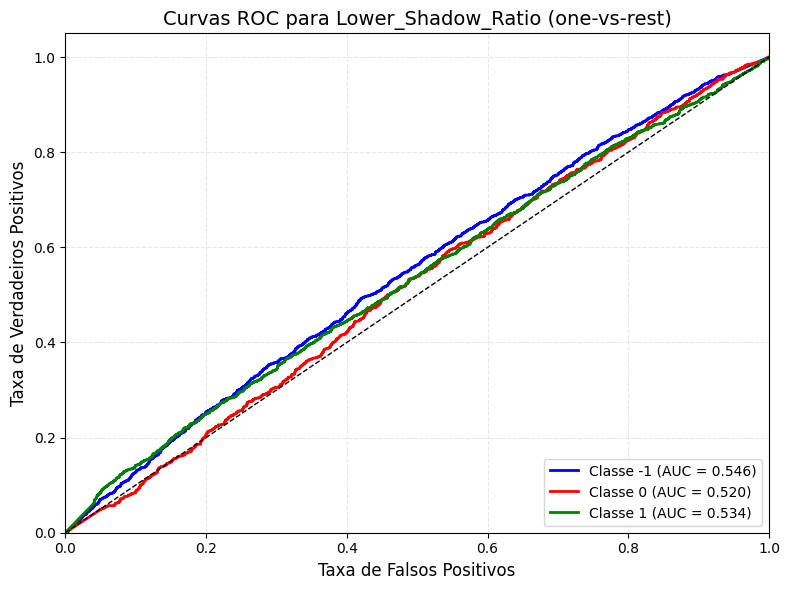

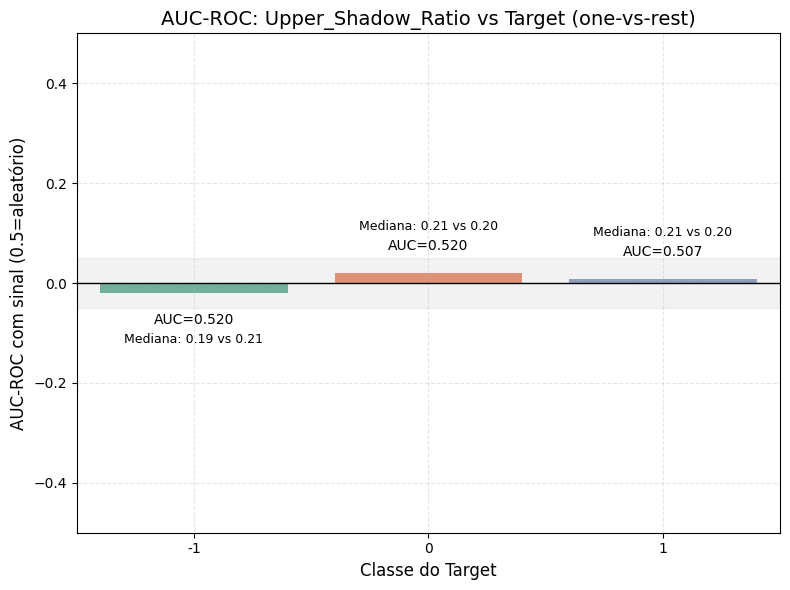

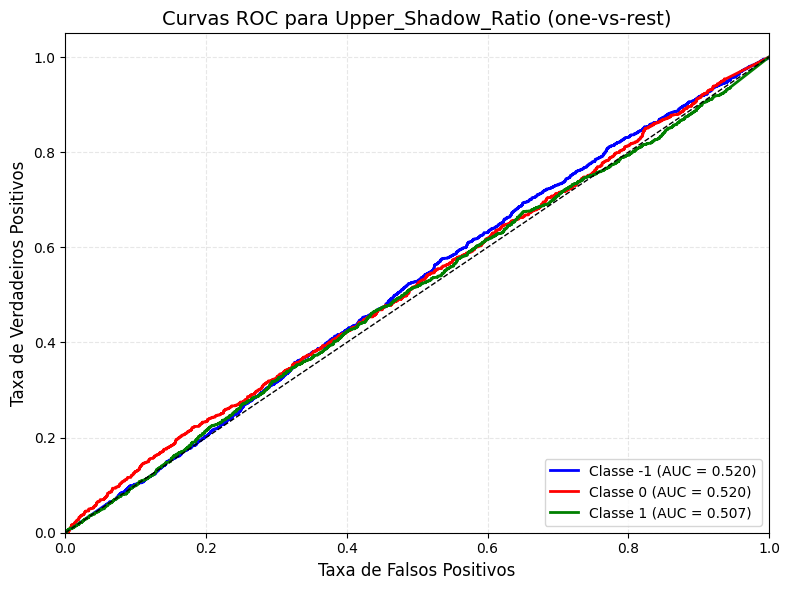

In [0]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import warnings
# Ignorar avisos
warnings.filterwarnings('ignore')

# Lista para armazenar resultados de ROC AUC
roc_results = []

for feature in features:
    if pd_feat[feature].nunique() <= 1:
        continue  # Ignorar colunas constantes
    
    # Obter os valores da feature
    feature_values = pd_feat[feature].values
    
    # Verificar se há valores muito grandes ou infinitos
    problematic_values = ~np.isfinite(feature_values) | (np.abs(feature_values) > 1e15)
    if np.any(problematic_values):
        # Criar uma cópia para não modificar os dados originais
        feature_cleaned = feature_values.copy()
        # Substituir valores problemáticos por NaN
        feature_cleaned[problematic_values] = np.nan
        # Usar a versão limpa
        feature_values = feature_cleaned
    
    # Identificar índices válidos após limpeza
    valid_indices = ~np.isnan(feature_values)
    
    if np.sum(valid_indices) <= 1:
        print(f"Feature {feature} tem muito poucos valores válidos após limpeza, pulando.")
        continue
    
    try:
        # Calcular ROC AUC para cada classe vs. resto
        for target_class in [-1, 0, 1]:
            # Criar target binário (classe atual vs. resto)
            bin_target = (pd_feat['Target'] == target_class).astype(int)
            
            # Filtrar para usar apenas índices válidos
            X_valid = feature_values[valid_indices]
            y_valid = bin_target.values[valid_indices]
            
            # Verificar se há pelo menos dois valores de classe
            unique_classes = np.unique(y_valid)
            if len(unique_classes) < 2:
                print(f"Feature {feature} para classe {target_class} não tem ambas as classes, pulando.")
                continue
            
            # Calcular curva ROC
            # Para classes -1 e 0, invertemos o sinal da feature para que valores maiores
            # correspondam à classe positiva (direcionalidade)
            if target_class == -1 or target_class == 0:
                fpr, tpr, _ = roc_curve(y_valid, -X_valid)
                direction = -1
            else:
                fpr, tpr, _ = roc_curve(y_valid, X_valid)
                direction = 1
            
            # Calcular área sob a curva
            roc_auc = auc(fpr, tpr)
            
            # Se AUC < 0.5, inverter a direção
            if roc_auc < 0.5:
                roc_auc = 1 - roc_auc
                direction *= -1
                # Recalcular as curvas com a direção correta
                if direction > 0:
                    fpr, tpr, _ = roc_curve(y_valid, X_valid)
                else:
                    fpr, tpr, _ = roc_curve(y_valid, -X_valid)
            
            # Calcular valor mediano da feature para cada classe
            class_values = pd_feat[pd_feat['Target'] == target_class][feature].dropna()
            non_class_values = pd_feat[pd_feat['Target'] != target_class][feature].dropna()
            
            class_median = np.median(class_values) if len(class_values) > 0 else 0
            non_class_median = np.median(non_class_values) if len(non_class_values) > 0 else 0
            
            # Armazenar resultados para o plot de barras e para o plot ROC
            roc_results.append({
                'Feature': feature,
                'Classe': str(target_class),
                'ROC_AUC': roc_auc,
                'Direction': direction,
                'Signed_AUC': (roc_auc - 0.5) * direction,  # Para o gráfico de barras
                'Class_Median': class_median,
                'Non_Class_Median': non_class_median,
                'FPR': fpr,  # Para plotar a curva ROC
                'TPR': tpr   # Para plotar a curva ROC
            })
    except Exception as e:
        print(f"Erro ao processar feature {feature}: {e}")

# Transformar em DataFrame
plot_final = pd.DataFrame(roc_results)

# Verificar se temos resultados
if len(plot_final) == 0:
    print("Nenhum resultado válido encontrado para plotar.")
else:
    # Definir um tamanho para os gráficos
    fig_width = 8
    fig_height = 6
    
    # Para cada feature, plotar o gráfico de barras AUC-ROC
    for feature in plot_final['Feature'].unique():
        subset = plot_final[plot_final['Feature'] == feature]
        
        # 1. GRÁFICO DE BARRAS AUC
        plt.figure(figsize=(fig_width, fig_height))
        ax = sns.barplot(data=subset, x='Classe', y='Signed_AUC', palette="Set2")
        
        # Definir limites do eixo Y
        max_signed_auc = max(abs(subset['Signed_AUC'].max()), abs(subset['Signed_AUC'].min()))
        y_limit = max(0.5, max_signed_auc * 1.2)  # No mínimo 0.5 para contexto
        plt.ylim(-y_limit, y_limit)
        
        # Adicionar linha de referência em AUC = 0.5
        plt.axhline(0, color='black', linestyle='-', linewidth=1)
        plt.axhspan(-0.05, 0.05, alpha=0.1, color='gray', label='Próximo ao aleatório')
        
        # Adicionar textos
        for i, row in enumerate(subset.itertuples()):
            # Calcular posições verticais para textos
            if row.Signed_AUC >= 0:
                auc_text_pos = row.Signed_AUC + (y_limit * 0.08)
                median_text_pos = row.Signed_AUC + (y_limit * 0.16)
                va_auc = 'bottom'
                va_median = 'bottom'
            else:
                auc_text_pos = row.Signed_AUC - (y_limit * 0.08)
                median_text_pos = row.Signed_AUC - (y_limit * 0.16)
                va_auc = 'top'
                va_median = 'top'
            
            # Formatar valores para exibição
            class_median_str = f"{row.Class_Median:.2f}" if abs(row.Class_Median) < 10000 else f"{row.Class_Median:.2e}"
            non_class_median_str = f"{row.Non_Class_Median:.2f}" if abs(row.Non_Class_Median) < 10000 else f"{row.Non_Class_Median:.2e}"
            
            # Texto AUC
            ax.text(i, auc_text_pos, f"AUC={row.ROC_AUC:.3f}", ha='center', va=va_auc, fontsize=10)
            
            # Texto mediana
            ax.text(i, median_text_pos, 
                   f"Mediana: {class_median_str} vs {non_class_median_str}", 
                   ha='center', va=va_median, fontsize=9)
        
        plt.title(f"AUC-ROC: {feature} vs Target (one-vs-rest)", fontsize=14)
        plt.ylabel("AUC-ROC com sinal (0.5=aleatório)", fontsize=12)
        plt.xlabel("Classe do Target", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # 2. GRÁFICO DE CURVAS ROC
        plt.figure(figsize=(fig_width, fig_height))
        
        colors = cycle(['blue', 'red', 'green'])
        for (idx, row), color in zip(subset.iterrows(), colors):
            plt.plot(
                row['FPR'], row['TPR'],
                color=color, linewidth=2,
                label=f"Classe {row['Classe']} (AUC = {row['ROC_AUC']:.3f})"
            )
        
        # Adicionar linha diagonal de referência (classificador aleatório)
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
        plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
        plt.title(f'Curvas ROC para {feature} (one-vs-rest)', fontsize=14)
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

Infelizmente não foi possível utilizar todas as features. Eu tenho features próprias que não foi possível utilizar, mas sei também que esse não é o objetivo do trabalho. Espero que tenha saído a contento. Obrigado aos professores pelas orientações e paciência! Deus os abençoe!